# Smoker Status Prediction
**Author:** MT2025065

## Objective
To analyze the dataset, perform exploratory data analysis (EDA), and preprocess the data for machine learning modeling to predict smoker status.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Load Data

In [3]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (38984, 23)
Test dataset shape: (16708, 22)


## 2. Data Inspection & Cleaning

In [4]:
display(train_df.head())

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [5]:
print("--- Train Info ---")
train_df.info()
print("\n--- Test Info ---")
test_df.info()

--- Train Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin       

In [6]:
print("Missing values in Train:")
print(train_df.isnull().sum())
print("\nMissing values in Test:")
print(test_df.isnull().sum())

Missing values in Train:
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Missing values in Test:
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL         

In [7]:
duplicates = train_df.duplicated().sum()
print(f"Duplicate rows in Train: {duplicates}")

if duplicates > 0:
    train_df = train_df.drop_duplicates()
    print("Duplicates removed.")

Duplicate rows in Train: 5517
Duplicates removed.


## 3. Exploratory Data Analysis (EDA)

### 3.1 Target Distribution

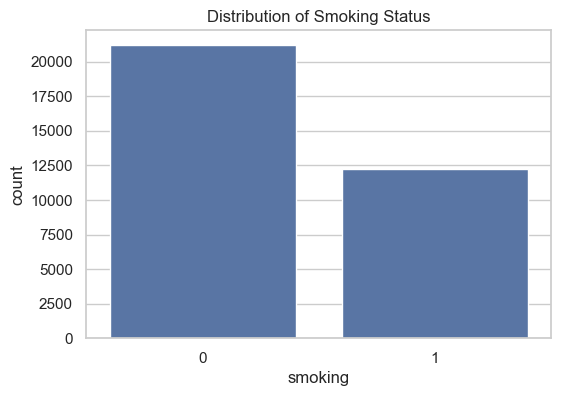

smoking
0    0.633729
1    0.366271
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='smoking', data=train_df)
plt.title('Distribution of Smoking Status')
plt.show()

print(train_df['smoking'].value_counts(normalize=True))

### 3.2 Numerical Features Distribution

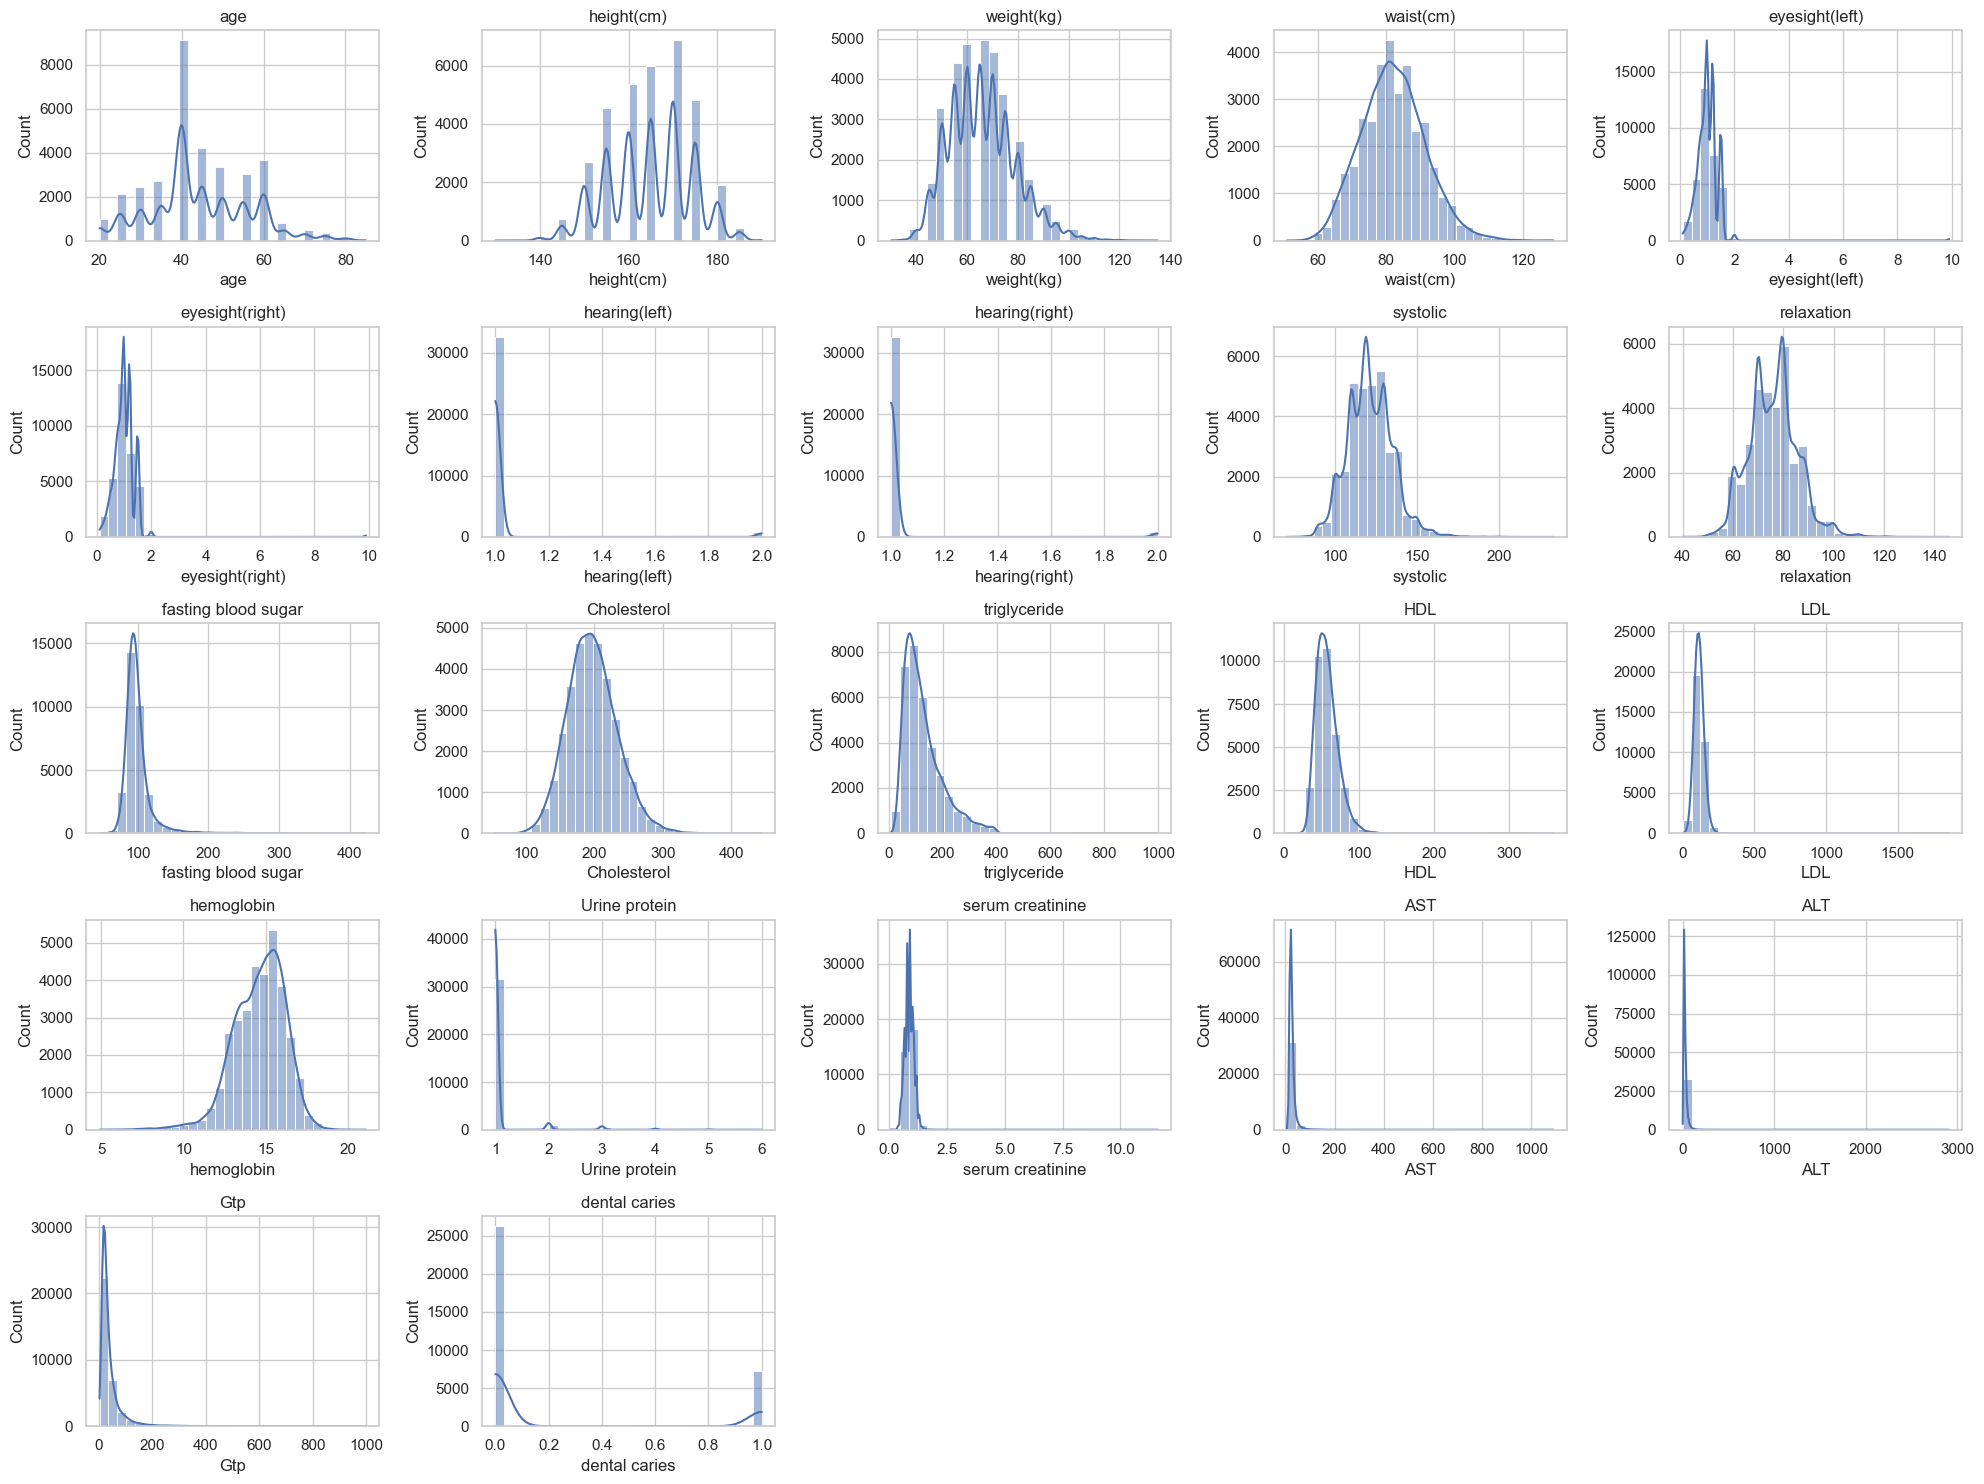

In [9]:
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
if 'smoking' in numerical_cols:
    numerical_cols.remove('smoking')

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(5, 5, i + 1)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(col)
    plt.tight_layout()
plt.show()

### 3.3 Correlation Analysis

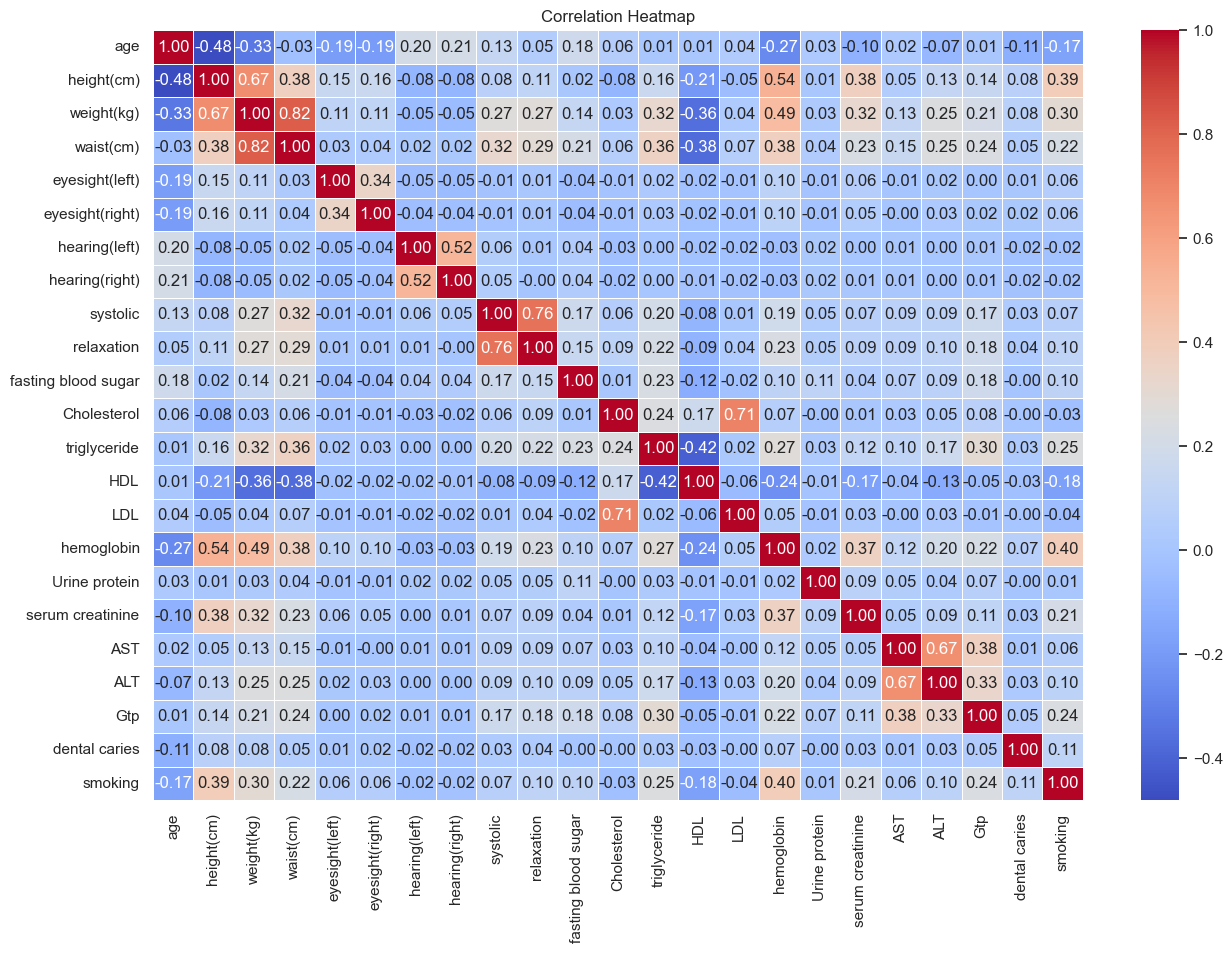

In [10]:
plt.figure(figsize=(15, 10))
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## 3.4 Target Value Analysis

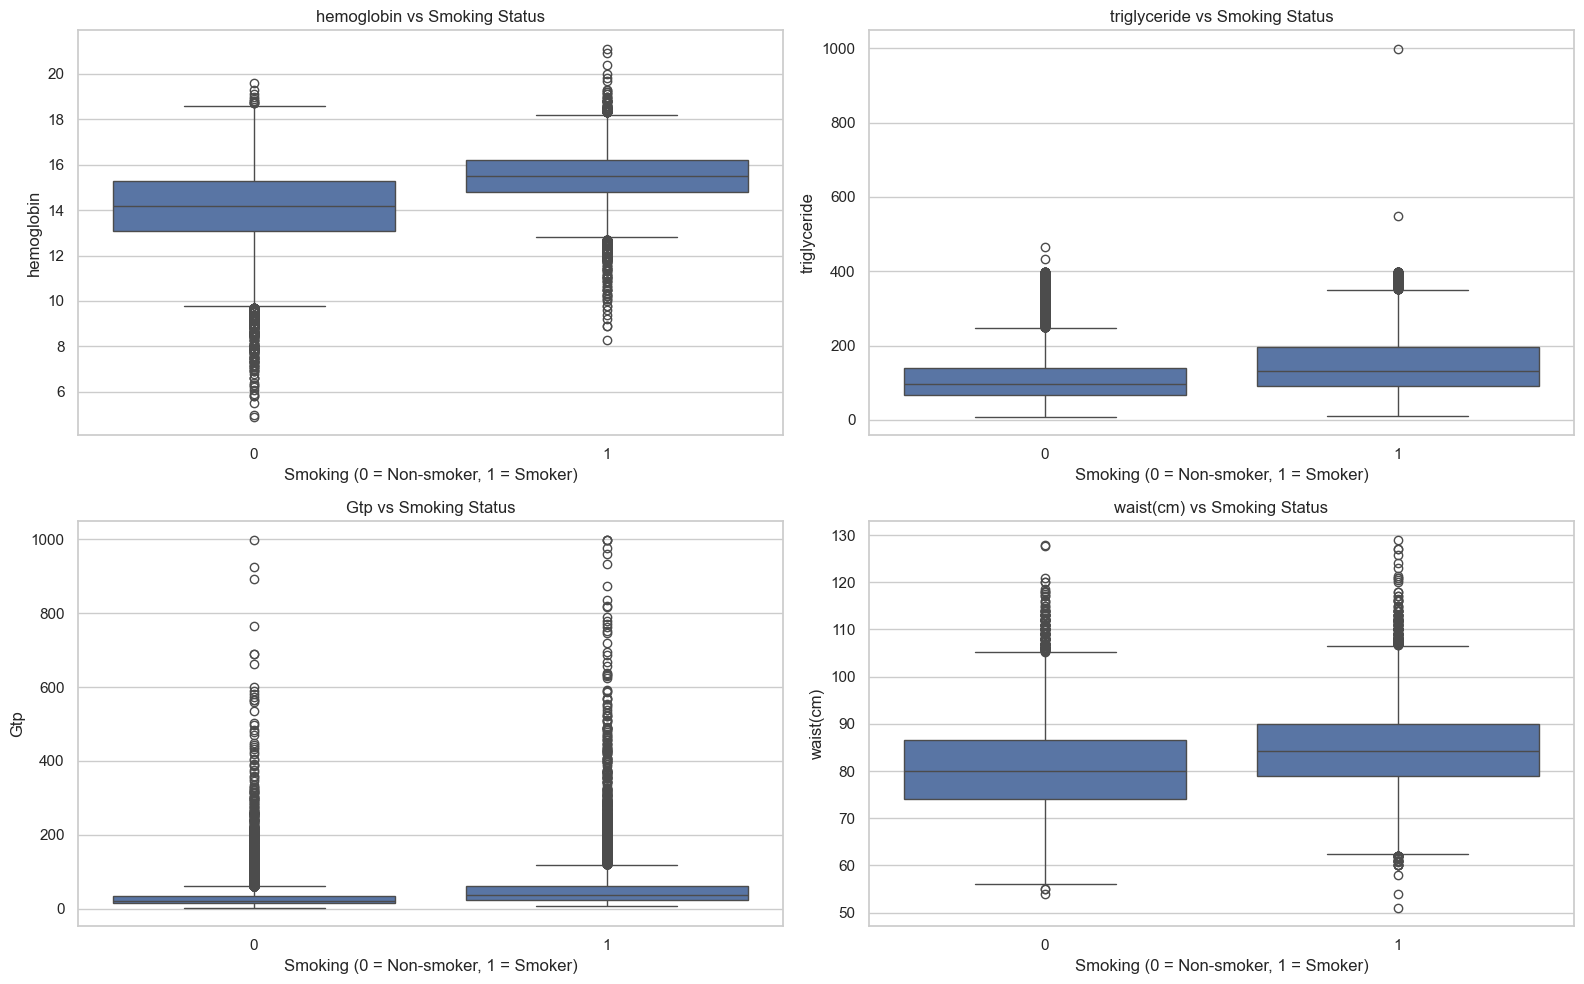

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['hemoglobin', 'triglyceride', 'Gtp', 'waist(cm)']

plt.figure(figsize=(16, 10))

for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='smoking', y=col, data=train_df)
    plt.title(f'{col} vs Smoking Status')
    plt.xlabel('Smoking (0 = Non-smoker, 1 = Smoker)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


## 4. Preprocessing



### 4.1 Feature Selection & Encoding


In [11]:
object_cols = train_df.select_dtypes(include=['object']).columns
print(f"Object columns: {object_cols}")

Object columns: Index([], dtype='object')


### 4.2 Feature Scaling

In [12]:
scaler = StandardScaler()

X = train_df.drop('smoking', axis=1)
y = train_df['smoking']

### 4.3 Train-Validation Split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (26773, 22)
X_val shape: (6694, 22)


### 4.4 Applying Scaling

In [14]:
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_df)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_df.columns)

print("Scaling complete.")
display(X_train_scaled.head())

Scaling complete.


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,0.900899,-0.507734,-0.457514,-0.190173,-0.025978,0.378383,-0.15861,-0.162768,-0.842397,0.407455,...,0.015080,-0.289568,1.325205,-0.651617,-0.212859,-0.382624,-0.277043,-0.290786,-0.385764,1.906203
1,0.486214,-1.051302,-1.622461,-1.706161,-1.422208,-1.018203,-0.15861,-0.162768,2.080745,2.470018,...,-0.138153,-0.494971,-0.278640,-0.014493,-0.212859,-0.821866,-0.009894,-0.326725,-0.385764,-0.524603
2,0.071528,-0.507734,0.319117,-0.437462,-0.424901,-0.220154,-0.15861,-0.162768,-0.257769,-0.623826,...,-0.723222,-0.768842,-0.075336,-1.161316,-0.212859,-1.261108,0.791550,1.793621,-0.303866,-0.524603
3,-0.343158,0.035835,-0.457514,-0.437462,-0.624363,-0.419667,-0.15861,-0.162768,-1.646262,-1.551980,...,-1.336152,1.832932,0.173147,-1.352454,-0.212859,-0.382624,-0.437332,-0.650167,-0.488136,1.906203
4,0.486214,0.579403,-0.845830,-1.082563,-0.025978,0.378383,-0.15861,-0.162768,1.203802,0.201199,...,-0.235664,-0.426503,-0.368997,0.495207,-0.212859,0.495859,-0.170183,-0.470477,-0.467661,-0.524603
